# Perplexity ratio data length binning

The purpose of this notebook is to load text fragment data with perplexity ratio scores already added and bin it by text fragment length. The plan is to handle data as Pandas dataframes and store it using hdf5. The text fragments will be put into overlapping length bins so that feature engineering and classifier training can be conducted separately for different length regimes. This general strategy is based on early observations of classifier performance on short fragments, long fragments and un-binned fragments.

## 1. Run set-up

In [1]:
# Change working directory to parent so we can import as we would from __main__.py
print(f'Working directory: ', end = '')
%cd ..

import h5py
import numpy as np
import pandas as pd

import configuration as config
import functions.notebook_plotting as plot_funcs
import functions.notebook_helper as helper_funcs

Working directory: /mnt/arkk/llm_detector/classifier


In [2]:
# Fraction of data to use, set to 1 to use all
sample_fraction = 1.0

# The dataset we want to bin - omit the file extension, it will be 
# added appropriately for the input and output files
dataset_name = 'falcon-7b_scores_v2_10-300_words'

# Construct input and output file paths
input_file = f'{config.HANS_DATA_PATH}/{dataset_name}.json'
output_file = f'{config.DATA_PATH}/{dataset_name}_stage_I.h5'

# Bins for 10-300 word dataset
bins = {
    'combined': [0, np.inf],
    'bin_001_050': [1, 50],
    'bin_026_075': [26, 75],
    'bin_051_100': [51, 100],
    'bin_076_125': [76, 125],
    'bin_101_150': [101, 150],
    'bin_126_175': [126, 175],
    'bin_151_200': [151, 200],
    'bin_176_225': [176, 225],
    'bin_201_250': [201, 250],
    'bin_226_275': [226, 275],
    'bin_251_300': [251, 300]
}

## 2. Load and prepare data

In [3]:
# Load the data
data_df = pd.read_json(input_file)

# Replace and remove string 'OOM' and 'NAN' values
data_df.replace('NAN', np.nan, inplace = True)
data_df.replace('OOM', np.nan, inplace = True)
data_df.dropna(inplace = True)

# Use the index to add a unique fragment id
data_df.reset_index(inplace = True)
data_df.rename({'index': 'Fragment ID'}, axis = 1, inplace = True)

# Enforce dtypes
data_df = data_df.astype({
    'Fragment ID': np.int64,
    'Source record num': np.int64,
    'Fragment length (words)': np.int64,
    'Fragment length (tokens)': np.int64,
    'Dataset': object, #pd.StringDtype(), pandas recommends these, but PyTables for hdf5 can't use them
    'Source': object, #pd.StringDtype(),
    'Generator': object, #pd.StringDtype(),
    'String': object, #pd.StringDtype(),
    'Perplexity': np.float64,
    'Cross-perplexity': np.float64,
    'Perplexity ratio score': np.float64,
    'Reader time (seconds)': np.float64,
    'Writer time (seconds)': np.float64,
    'Reader peak memory (GB)': np.float64,
    'Writer peak memory (GB)': np.float64
})

# Remove outliers with extreme perplexity or cross perplexity scores
data_df = data_df[data_df['Perplexity'] < 7.5]
data_df = data_df[data_df['Cross-perplexity'] < 7.5]
data_df = data_df[data_df['Perplexity ratio score'] > 0.4]
data_df = data_df[data_df['Perplexity ratio score'] < 1.45]

# Shuffle the deck, resetting the index, taking a sample if
# sample fraction is less than 1
data_df = data_df.sample(frac = sample_fraction).reset_index(drop = True)

data_df.head()
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55774 entries, 0 to 55773
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment ID               55774 non-null  int64  
 1   Source record num         55774 non-null  int64  
 2   Fragment length (words)   55774 non-null  int64  
 3   Fragment length (tokens)  55774 non-null  int64  
 4   Dataset                   55774 non-null  object 
 5   Source                    55774 non-null  object 
 6   Generator                 55774 non-null  object 
 7   String                    55774 non-null  object 
 8   Perplexity                55774 non-null  float64
 9   Cross-perplexity          55774 non-null  float64
 10  Perplexity ratio score    55774 non-null  float64
 11  Reader time (seconds)     55774 non-null  float64
 12  Writer time (seconds)     55774 non-null  float64
 13  Reader peak memory (GB)   55774 non-null  float64
 14  Writer

## 3. Generate hdf5 data structure

OK, let's start structuring the dataset. We want two top level groups, one for training data and one for reserved testing data. Inside those groups will live datasets for the bins. We will also use attributes to save some metadata etc.

In [4]:
# Prepare the hdf5 output - create or open for read/write
output = h5py.File(output_file, 'a')

# Create the top-level groups
_ = output.require_group('training')
_ = output.require_group('testing')

print(f'Top level groups: {(list(output.keys()))}')

# Next, we need to add a group for each fragment length bin,
# and one for the un-binned data
for group in output.keys():

    # Add the un-binned data group
    _ = output.require_group(f'{group}/combined')

    # Loop on the bins and add a group for each
    for bin in bins.keys():
        _ = output.require_group(f'{group}/{bin}')

# Finally, add the bins under group bins
output.attrs.update(bins)

print(f'\nBin attributes:')
for key, value in output.attrs.items():
    print(f' {key}: {value}')

output.close()

Top level groups: ['master', 'testing', 'training']

Bin attributes:
 bin_001_050: [ 1 50]
 bin_026_075: [26 75]
 bin_051_100: [ 51 100]
 bin_076_125: [ 76 125]
 bin_101_150: [101 150]
 bin_126_175: [126 175]
 bin_151_200: [151 200]
 bin_176_225: [176 225]
 bin_201_250: [201 250]
 bin_226_275: [226 275]
 bin_251_300: [251 300]
 combined: [ 0. inf]


## 4. Populate hdf5 data structure

OK, the basic data structure is ready to go. Next thing to do is add data.

In [5]:
# Reopen out hdf5 file with pandas so we can work with dataframes
data_lake = pd.HDFStore(output_file)

# Add the raw data set at the top level as 'master' incase we want it later.
data_lake['master'] = data_df

# Next, get rid of un-trainable/unnecessary features
feature_drops = [
    'Fragment ID',
    'Source record num',
    'Dataset',
    'Generator',
    'Reader time (seconds)',
    'Writer time (seconds)',
    'Reader peak memory (GB)',
    'Writer peak memory (GB)'
]

data_df.drop(feature_drops, axis = 1, inplace = True)

# Drop any data that contains nan
data_df.dropna(inplace = True)

# Split the data into training and testing
training_df = data_df.sample(frac = 0.7, random_state = 42)
testing_df = data_df.drop(training_df.index)

# Now do the same for the bins
for bin_id, bin_range in bins.items():

    # Pull the fragments for this bin
    bin_training_df = training_df[(training_df['Fragment length (words)'] >= bin_range[0]) & (training_df['Fragment length (words)'] <= bin_range[1])]
    bin_testing_df = testing_df[(testing_df['Fragment length (words)'] >= bin_range[0]) & (testing_df['Fragment length (words)'] <= bin_range[1])]

    # Fix the index
    bin_training_df.reset_index(inplace = True, drop = True)
    bin_testing_df.reset_index(inplace = True, drop = True)

    # Split un-binned data into features and labels
    bin_training_labels, bin_testing_labels = helper_funcs.make_labels(bin_training_df, bin_testing_df)

    # Add the data to the data lake
    data_lake.put(f'training/{bin_id}/features', bin_training_df)
    data_lake.put(f'training/{bin_id}/labels', bin_training_labels)
    data_lake.put(f'testing/{bin_id}/features', bin_training_df)
    data_lake.put(f'testing/{bin_id}/labels', bin_training_labels)

data_lake.close()

## 5. Sanity check results

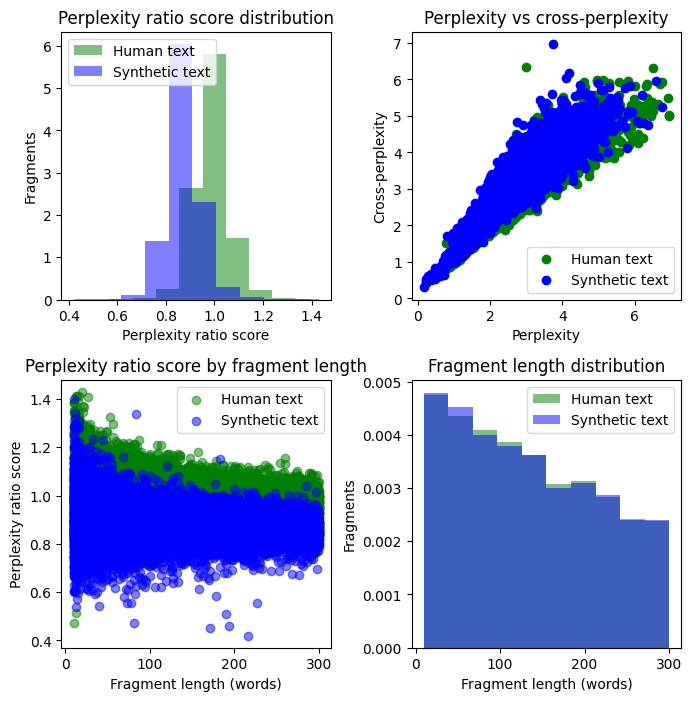

In [6]:
# Makes some plots with the combined data

# Open a connection to the hdf5 dataset via PyTables with Pandas
data_lake = pd.HDFStore(output_file)

# Pull the training features from the combined bin
bin_training_features_df = data_lake[f'training/combined/features']
data_lake.close()

# Make the plots
plot_funcs.data_exploration_plot(bin_training_features_df).show()

In [7]:
# Open the data lake to check out the result
data_lake = h5py.File(output_file, 'a')

# Print the result
for group in data_lake.keys():
    print(f'\n{group} contains:')

    for subgroup in data_lake[group]:

        if 'bin' in subgroup:
            print(f'  {subgroup} contains: ', end = '')

            for subsubgroup in data_lake[group][subgroup].keys():
                print(f'{subsubgroup} ', end = '')
            
            print()

        else:
            print(f' {subgroup}')

data_lake.close()


master contains:
 axis0
 axis1
 block0_items
 block0_values
 block1_items
 block1_values
 block2_items
 block2_values

testing contains:
  bin_001_050 contains: features labels 
  bin_026_075 contains: features labels 
  bin_051_100 contains: features labels 
  bin_076_125 contains: features labels 
  bin_101_150 contains: features labels 
  bin_126_175 contains: features labels 
  bin_151_200 contains: features labels 
  bin_176_225 contains: features labels 
  bin_201_250 contains: features labels 
  bin_226_275 contains: features labels 
  bin_251_300 contains: features labels 
  combined contains: features labels 

training contains:
  bin_001_050 contains: features labels 
  bin_026_075 contains: features labels 
  bin_051_100 contains: features labels 
  bin_076_125 contains: features labels 
  bin_101_150 contains: features labels 
  bin_126_175 contains: features labels 
  bin_151_200 contains: features labels 
  bin_176_225 contains: features labels 
  bin_201_250 contains: f

In [8]:
# Reopen out hdf5 file with pandas so we can work with dataframes
data_lake = pd.HDFStore(output_file)

print('Combined training features:\n')
print(data_lake['training/combined/features'].info())
print('\nCombined training labels:\n')
print(data_lake['training/combined/labels'].info())
print('\nBin 100 training features:\n')
print(data_lake['training/bin_051_100/features'].info())
print('\nBin 100 training labels:\n')
print(data_lake['training/bin_051_100/labels'].info())

data_lake.close()

Combined training features:

<class 'pandas.core.frame.DataFrame'>
Index: 39042 entries, 0 to 39041
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment length (words)   39042 non-null  int64  
 1   Fragment length (tokens)  39042 non-null  int64  
 2   Source                    39042 non-null  object 
 3   String                    39042 non-null  object 
 4   Perplexity                39042 non-null  float64
 5   Cross-perplexity          39042 non-null  float64
 6   Perplexity ratio score    39042 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 2.4+ MB
None

Combined training labels:

<class 'pandas.core.series.Series'>
Index: 39042 entries, 0 to 39041
Series name: None
Non-Null Count  Dtype
--------------  -----
39042 non-null  int64
dtypes: int64(1)
memory usage: 610.0 KB
None

Bin 100 training features:

<class 'pandas.core.frame.DataFrame'>
Index: 8085 e

In [9]:
# Reopen out hdf5 file with pandas so we can work with dataframes
data_lake = pd.HDFStore(output_file)

for (path, subgroups, subkeys) in data_lake.walk():

    for subgroup in subgroups:

        print("GROUP: {}/{}".format(path, subgroup))

    for subkey in subkeys:

        key = "/".join([path, subkey])

        print("KEY: {}".format(key))

data_lake.close()

GROUP: /testing
GROUP: /training
KEY: /master
GROUP: /testing/bin_001_050
GROUP: /testing/bin_026_075
GROUP: /testing/bin_051_100
GROUP: /testing/bin_076_125
GROUP: /testing/bin_101_150
GROUP: /testing/bin_126_175
GROUP: /testing/bin_151_200
GROUP: /testing/bin_176_225
GROUP: /testing/bin_201_250
GROUP: /testing/bin_226_275
GROUP: /testing/bin_251_300
GROUP: /testing/combined
GROUP: /training/bin_001_050
GROUP: /training/bin_026_075
GROUP: /training/bin_051_100
GROUP: /training/bin_076_125
GROUP: /training/bin_101_150
GROUP: /training/bin_126_175
GROUP: /training/bin_151_200
GROUP: /training/bin_176_225
GROUP: /training/bin_201_250
GROUP: /training/bin_226_275
GROUP: /training/bin_251_300
GROUP: /training/combined
KEY: /training/bin_001_050/features
KEY: /training/bin_001_050/labels
KEY: /training/bin_026_075/features
KEY: /training/bin_026_075/labels
KEY: /training/bin_051_100/features
KEY: /training/bin_051_100/labels
KEY: /training/bin_076_125/features
KEY: /training/bin_076_125/lab

OK, I think we are happy with this to start with. Let's move on and do some feature engineering in the bins.